In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from autophasemap import compute_elastic_kmeans, plot_clusters, compute_BIC

color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd"]
bkg_spectra_color = "#717581"

In [3]:
# create synthetic data
class DataSet:
    def __init__(self, C, P, n_domain = 100):
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = C.shape[0]
        self.P = P
        self.C = C
        self.n_clusters = 3
        
    def g(self, t, p):
        out = np.zeros(self.t.shape)
        for i in range(1,p+1):
            zi = np.random.normal(1, 0.1)
            mean = (2*i-1)/(2*p)
            std = 1/(3*p)
            out += zi*self.phi(t, mean, std)

        return out
    
    def phi(self, t, mu, sigma):
        factor = 1/(2*(sigma**2))
        return np.exp(-factor*(t-mu)**2)
    
    def gamma(self):
        a = np.random.uniform(-3, 3)
        if a==0:
            gam = self.t
        else:
            gam = (np.exp(a*self.t)-1)/(np.exp(a)-1)
        return gam
    
    def generate(self):
        self.F = [self.g(self.gamma(), self.P[i]) for i in range(self.N)]

        return

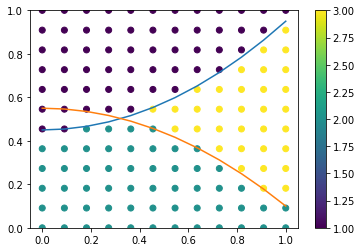

In [4]:
n_grid = 12
x = np.linspace(0,1, n_grid)
y = np.linspace(0,1, n_grid)
X,Y = np.meshgrid(x,y)
points = np.vstack([X.ravel(), Y.ravel()]).T
phase1 = lambda x : 0.5*(x)**2+0.45
phase2 = lambda x : -0.45*(x)**2+0.55

# plot the dummy phase map
def get_label(c):
    if c[1]-phase1(c[0])>0:
        label = 1
    elif c[1]-phase2(c[0])<0:
        label = 2
    else:
        label = 3
        
    return label

labels = [get_label(p) for p in points]

fig, ax = plt.subplots()
sc = ax.scatter(points[:,0], points[:,1], c=labels)
ax.plot(x, phase1(y))
ax.plot(x, phase2(y))
ax.set_ylim([0,1])
cbar = plt.colorbar(sc)
plt.show()

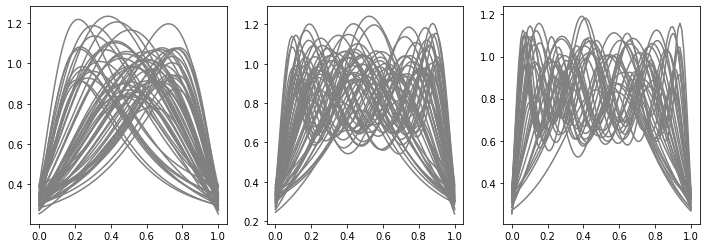

In [5]:
n_domain = 200

data = DataSet(points, labels)
data.generate()
fig, axs = plt.subplots(1, 3, figsize=(4*3, 4))
for i in range(data.N):
    axs[data.P[i]-1].plot(data.t, data.F[i], color='grey')
plt.show()

In [6]:
N_CLUSTERS = 3
MAX_ITER = 100
VERBOSE = 3

out = compute_elastic_kmeans(data, N_CLUSTERS, 
    max_iter=MAX_ITER, 
    verbose=VERBOSE, 
    smoothen=True
    )
BIC = compute_BIC(data, out.fik_gam, out.qik_gam, out.delta_n)
print('BIC with %d clusters is :%.2f'%(N_CLUSTERS, BIC))

(0:00:02.348900)	Iteration : 0	Error : 0.8154
(0:00:14.031702)	Iteration : 10	Error : 0.0160
(0:00:25.766567)	Iteration : 20	Error : 0.0074
(0:00:37.499344)	Iteration : 30	Error : 0.0141
(0:00:49.419219)	Iteration : 40	Error : 0.0122
(0:01:01.259875)	Iteration : 50	Error : 0.0077
(0:01:12.959322)	Iteration : 60	Error : 0.0129
(0:01:24.778036)	Iteration : 70	Error : 0.0042
(0:01:36.541407)	Iteration : 80	Error : 0.0076
(0:01:48.344134)	Iteration : 90	Error : 0.0076
Total iterations 99	Error : 0.0062 and took 0:01:58.983384
BIC with 3 clusters is :-810.94


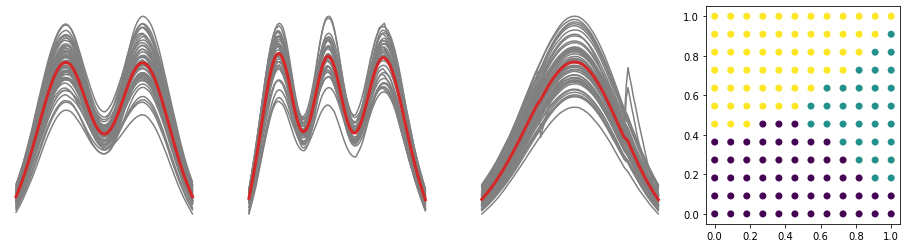

In [7]:
fig, axs = plt.subplots(1,4, figsize=(4*4, 4))
for k, ax in enumerate(axs):
    if k==3:
        ax.scatter(data.C[:,0], data.C[:,1], c=out.delta_n)
        continue
    Mk = np.argwhere(out.delta_n==k).squeeze()
    for i in Mk:
        ax.plot(data.t, out.fik_gam[i,k,:], color='grey')
    
    ax.plot(data.t, out.templates[k], lw=3.0, color='tab:red') 
    ax.axis('off')
plt.show()